In [1]:
using Pkg
Pkg.activate(".")

Activating environment at `~/Research/PulsarNoise/Project.toml`


In [2]:
using CARMA
using DelimitedFiles
using Ensemble
using HDF5
using Printf
using PulsarNoise
using PyPlot
using PyCall
using Statistics

sns = pyimport("seaborn")
sns.set_context("notebook")
sns.set_palette("colorblind")
sns.set_style("ticks")

┌ Info: Precompiling PulsarNoise [ab448884-4509-47d2-8b84-bfba4027e5a3]
└ @ Base loading.jl:1273
┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/wfarr/.julia/packages/PyPlot/4wzW1/src/init.jl:192


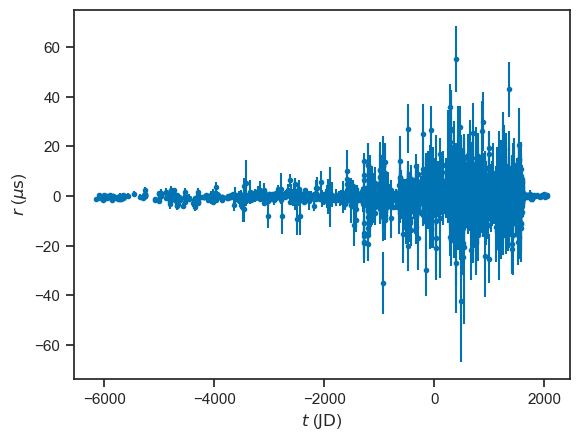

PyObject Text(29.0, 0.5, '$r$ ($\\mu\\mathrm{s}$)')

In [6]:
d = readdlm("DR2/release/VersionA/J1713+0747/residuals.dat")
errorbar(d[:,1], d[:,2]*1e6, d[:,3]*1e6, fmt=".")
xlabel(L"$t$ ($\mathrm{JD}$)")
ylabel(L"$r$ ($\mu\mathrm{s}$)")

In [7]:
ts, rs, drs = read_tempo2_residuals("DR2/release/VersionA/J1713+0747/residuals.dat");

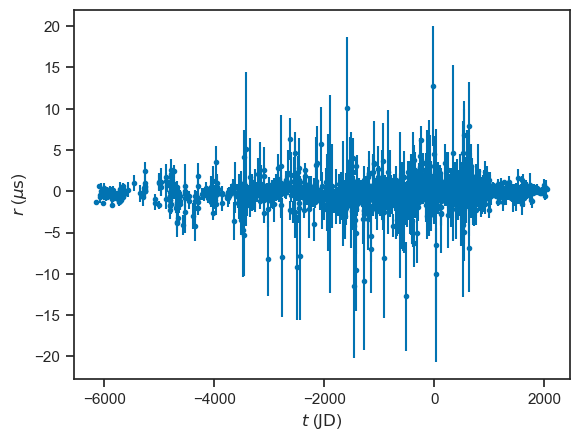

PyObject Text(29.0, 0.5, '$r$ ($\\mu\\mathrm{s}$)')

In [8]:
errorbar(ts, rs*1e6, drs*1e6, fmt=".")
xlabel(L"$t$ ($\mathrm{JD}$)")
ylabel(L"$r$ ($\mu\mathrm{s}$)")

In [9]:
post = Kalman.CARMAKalmanPosterior(ts, rs, drs, 3, 2)
ns = EnsembleNest.NestState(x -> Kalman.log_likelihood(post, x), x->Kalman.log_prior(post, x), Kalman.init(post, 1024), 32);

In [36]:
EnsembleNest.run!(ns, 0.1, verbose=false, ckpt_file="J1713.ckpt")

Save the state to `J1713.ns`; if you don't want to run the sampler above, you can always re-load the state from `J1713.ns`.

In [38]:
h5open("J1713.ns", "w") do f
    write(f, ns)
end

1.0

In [11]:
h5open("J1713.ns", "r") do f
    global ns = EnsembleNest.NestState(f, logl=x->Kalman.log_likelihood(post, x), logp=x->Kalman.log_prior(post, x))
end;

In [13]:
ps, logls = EnsembleNest.postsample(ns);

In [14]:
fs = Kalman.psdfreq(post)
fs = exp.(range(log(minimum(fs)), stop=log(maximum(fs)), length=1024))
Ps = Array{Float64,1}[]
for j in 1:size(ps,2)
    push!(Ps, Kalman.psd(post, ps[:,j], fs))
end
Ps = hcat(Ps...);

In [15]:
m = median(Ps, dims=2)
h = zeros(size(Ps, 1))
l = zeros(size(Ps, 1))
for i in 1:size(Ps, 1)
    h[i] = quantile(vec(Ps[i,:]), 0.84)
    l[i] = quantile(vec(Ps[i,:]), 0.16)
end

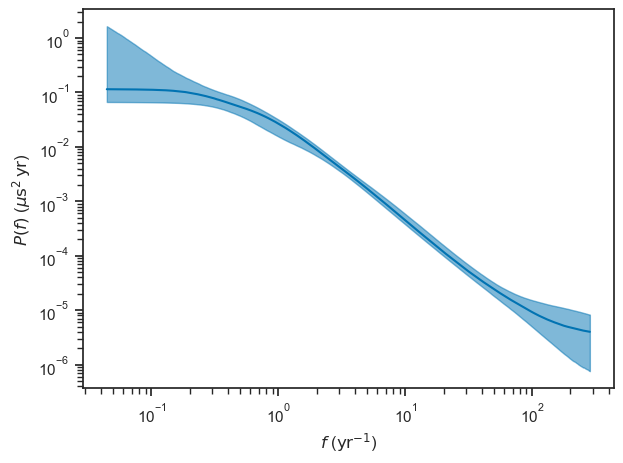

In [16]:
loglog(fs*365.25, median(Ps, dims=2)*1e12/365.25)
fill_between(fs*365.25, h*1e12/365.25, l*1e12/365.25, alpha=0.5, color=sns.color_palette()[1])
xlabel(L"$f$ ($\mathrm{yr}^{-1}$)")
ylabel(L"$P(f)$ ($\mu\mathrm{s}^2 \, \mathrm{yr}$)")

tight_layout()
savefig("J1713.pdf")

There doesn't seem to be much structure in the residuals after the red-noise model is done.  `whiten` uses the fitted CARMA model to whiten the time series to iid  $N(0,1)$.

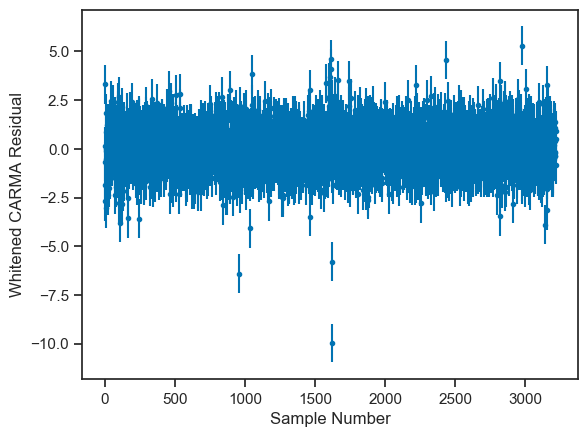

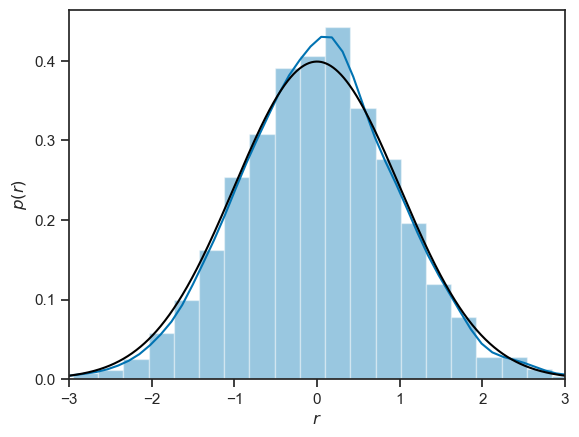

(-3, 3, 0.0, 0.46413558896821616)

In [23]:
j = rand(1:size(ps,2))
wr = Kalman.whiten(post, ps[:,j])
errorbar(collect(1:size(wr,1)), wr, ones(length(wr)), fmt=".")
xlabel("Sample Number")
ylabel("Whitened CARMA Residual")

figure()
sns.distplot(wr)
xs = collect(range(-3, stop=3, length=1024))
plot(xs, 1/sqrt(2*pi)*exp.(-0.5*xs.*xs), color="k")
xlabel(L"$r$")
ylabel(L"$p(r)$")
axis(xmin=-3, xmax=3)

Here is the ACF of the tempo2 residuals, followed by the ACF of the residuals of the CARMA-whitened residual.  You can see that the CARMA model has eliminated a lot of structure in the residuals, though it's not clear that there isn't still some structure remaining.

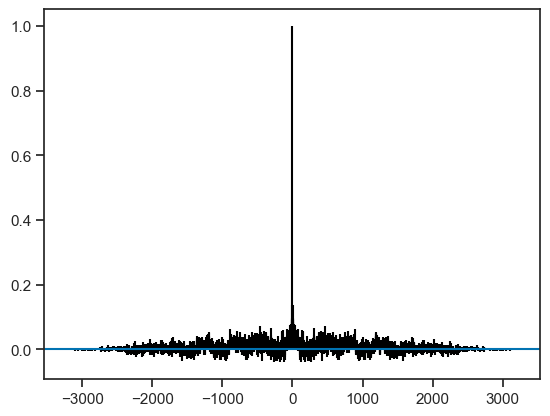

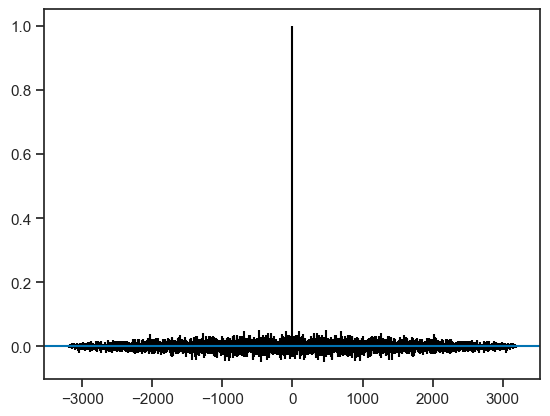

In [24]:
acorr(rs, maxlags=nothing, label="Raw Residuals")
figure()
acorr(Kalman.whiten(post, ps[:,j]), maxlags=nothing);

The RMS timing residual after removing (as much as possible) the correlated noise:

In [29]:
println(@sprintf("Raw residual RMS is %.2g microseconds", std(1e6*rs)))

println(@sprintf("CARMA-residual RMS is %.2g microseconds", std(1e6*Kalman.residuals(post, ps[:,j])[1])))

iyr = argmin(abs.(fs*365.25 .- 1))
println(@sprintf("sqrt(f*P(f)) = %.2g nanoseconds at f = 1 / yr", sqrt(mean(Ps[iyr,:]*1e18/365.25))))

Raw residual RMS is 1.1 microseconds
CARMA-residual RMS is 1.1 microseconds
sqrt(f*P(f)) = 1.6e+02 nanoseconds at f = 1 / yr


In [31]:
alphas = log.(Ps[iyr+1,:]./Ps[iyr,:])/log(fs[iyr+1]/fs[iyr])
println(@sprintf("Spectral index at f = 1/yr is %.2g +/- %.2g", mean(alphas), std(alphas)))

Spectral index at f = 1/yr is -1.3 +/- 0.25
